In [1]:
import pandas as pd
import numpy as np

In [2]:
# each game is 9 char string, X starts

def create_game_tree():
    stack = [("", " " * 9, 0, 1., [])]  # (prev_board, board, depth, prob, moves)
    result = stack[:]
    while stack:
        _, board, depth, prob, moves = stack.pop()

        if is_game_over(board):
            # node = (board, board, depth + 1, prob, moves + [-1])
            # result.append(node)
            # if depth + 1 < 9:
                # stack.append(node)
            continue

        move_char = "X" if depth % 2 == 0 else "O"

        valid_moves = [i for i in range(9) if board[i] == " "]

        move_prob = 1. / len(valid_moves)
        for move in valid_moves:
            new_board = board[:move] + move_char + board[move+1:]
            next_node = (board, new_board, depth + 1, move_prob * prob, moves + [move])

            stack.append(next_node)
            result.append(next_node)
    return result


def is_game_over(board):
    return (
        board.count(" ") == 0 or
        any(board[i] != ' ' and board[i:i+3].count(board[i]) == 3 for i in range(0, 9, 3)) or
        any(board[i] != ' ' and board[i::3].count(board[i]) == 3 for i in range(0, 3)) or
        board[0] != ' ' and board[0::4].count(board[0]) == 3 or
        board[2] != ' ' and board[2:8:2].count(board[2]) == 3
    )

def print_board(board):
    print('\n'.join(board[i:i+3] for i in range(0, 9, 3)))

In [3]:
tree = create_game_tree()
game_df = pd.DataFrame(tree, columns=["prev_board", "board", "depth", "prob", "moves"])

prob_tot = game_df.groupby("depth").prob.sum()
game_df = game_df.assign(prob_norm=lambda x: x.prob / x.depth.map(prob_tot))

state_ids = {
    board: i
    for i, board in enumerate(
        sorted(game_df.board.unique(), key=lambda x: (x.count(" "), x), reverse=True)
    )
}

game_df = game_df.assign(state_id=lambda x: x.board.map(state_ids)).assign(
    is_game_over=lambda x: x.board.apply(is_game_over)
)

game_df.query('is_game_over').prob.sum()

1.0

In [4]:
game_df.groupby(['depth']).agg({
    'board': 'nunique',
    'prob': 'sum',
    'prob_norm': 'sum'
})

,board,prob,prob_norm
depth,,,
0,1,1.000000,1.0
1,9,1.000000,1.0
2,72,1.000000,1.0
3,252,1.000000,1.0
4,756,1.000000,1.0
5,1260,1.000000,1.0
6,1520,0.904762,1.0
7,1140,0.816667,1.0
8,390,0.552381,1.0


In [5]:
def game_state_to_target_binary(board):
    targets = np.zeros(9 * 3)
    for i, c in enumerate(' XO'):
        for j in range(len(board)):
            targets[i * 9 + j] = int(board[j] == c)
    return targets

def game_state_to_target_binary_alt(board):
    targets = np.zeros(9 * 3)
    depth = 9 - board.count(' ')
    for i, c in enumerate(' XO'):
        for j in range(len(board)):
            if depth % 2 == 0 and c != ' ':
                c = 'X' if c == 'O' else 'O'
            targets[i * 9 + j] = int(board[j] == c)
    return targets

def depth_label(board):
    depth = 9 - board.count(' ')
    target = np.zeros(9)
    target[depth - 1] = 1
    return target


In [6]:
grouped_df = game_df.groupby(['depth', 'state_id', 'board']).prob.sum().reset_index()

state_space = np.zeros((len(grouped_df), grouped_df.state_id.max() + 1))
state_space[np.arange(len(grouped_df)), grouped_df.state_id] = 1

targets = np.array([game_state_to_target_binary(b) for b in grouped_df.board])
targets_alt = np.array([game_state_to_target_binary_alt(b) for b in grouped_df.board])
targets_depth = np.array([depth_label(b) for b in grouped_df.board])
weight = grouped_df.prob.values

state_space.shape, targets.shape, weight.shape

((5478, 5478), (5478, 27), (5478,))

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_state_space = scaler.fit_transform(state_space)

pca = PCA(svd_solver='full')
pca.fit(scaled_state_space * np.sqrt(weight[:, np.newaxis]))


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PCA(svd_solver='full')

In [38]:
from sklearn.decomposition import PCA

pca1 = PCA(svd_solver='arpack')
pca1.fit(state_space * np.sqrt(weight[:, np.newaxis]))


PCA(svd_solver='arpack')

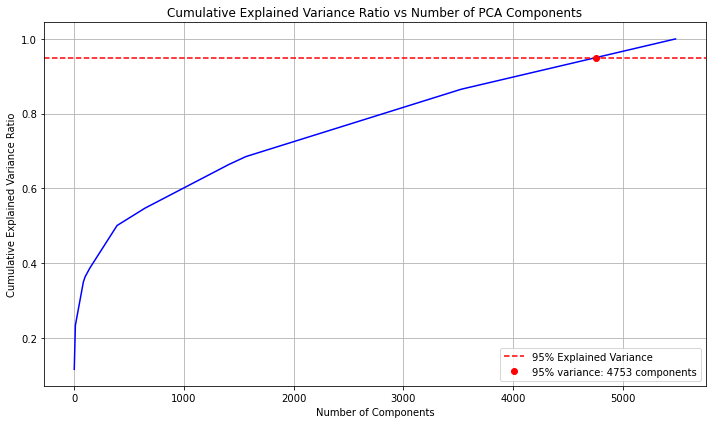

Number of components needed to explain 95% of variance: 4753


In [8]:
import matplotlib.pyplot as plt

# Calculate cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Add a horizontal line at 95% explained variance
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')

# Find the number of components needed to explain 95% of the variance
n_components_95 = next(i for i, ratio in enumerate(cumulative_var_ratio) if ratio >= 0.95) + 1
plt.plot(n_components_95, cumulative_var_ratio[n_components_95-1], 'ro', 
         label=f'95% variance: {n_components_95} components')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Number of components needed to explain 95% of variance: {n_components_95}")


In [9]:
import torch
from tqdm import trange
from sklearn.metrics import roc_auc_score


def calculate_accuracy_scores(pca, state_space, targets, start=10, step=100, end=None):
    accuracy_scores = {}

    states = torch.tensor(state_space, dtype=torch.float32).cuda()
    targets_cuda = torch.tensor(targets, dtype=torch.float32).cuda()

    pca_transform = pca.transform(state_space)
    
    if end is None:
        end = pca.n_components_
    
    for i in trange(start, end, step):
        projected_states = pca_transform[:, :i]
        projected_states = torch.tensor(projected_states, dtype=torch.float32).cuda()
        solution = torch.linalg.lstsq(projected_states, targets_cuda)
        predicted = projected_states @ solution.solution
        
        roc_auc_scores = []
        for col in range(targets.shape[1]):
            roc_auc = roc_auc_score(targets_cuda[:, col].cpu(), predicted[:, col].cpu())
            roc_auc_scores.append(roc_auc)
        
        accuracy_scores[i] = roc_auc_scores

    return accuracy_scores

In [10]:
from matplotlib import pyplot as plt
import numpy as np

accuracy_scores = calculate_accuracy_scores(pca, state_space, targets)
accuracy_scores_alt = calculate_accuracy_scores(pca, state_space, targets_alt)
accuracy_scores_depth = calculate_accuracy_scores(pca, state_space, targets_depth)

100%|██████████| 55/55 [00:06<00:00,  8.55it/s]


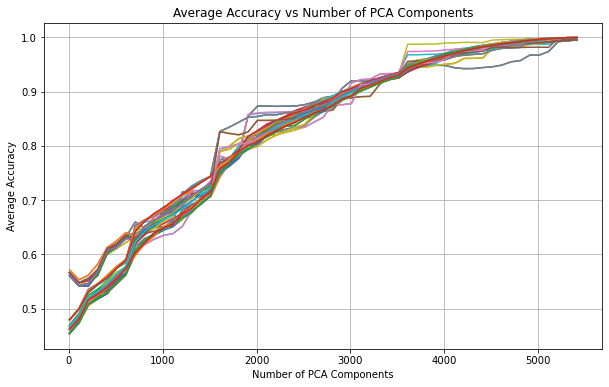

In [48]:

# Average each value entry
avg_accuracy_scores = {k: np.mean(v) for k, v in accuracy_scores.items()}
avg_accuracy_scores_alt = {k: np.mean(v) for k, v in accuracy_scores_alt.items()}

plt.figure(figsize=(10, 6))
# plt.plot(list(avg_accuracy_scores.keys()), list(avg_accuracy_scores.values()), label='Original Targets')
# plt.plot(list(avg_accuracy_scores_alt.keys()), list(avg_accuracy_scores_alt.values()), label='Alternating Targets')
plt.plot(list(accuracy_scores.keys()), list(accuracy_scores.values()), label='Original Targets')
plt.plot(list(accuracy_scores_alt.keys()), list(accuracy_scores_alt.values()), label='Alternating Targets')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs Number of PCA Components')
# plt.legend()
plt.grid(True)
plt.show()


In [179]:
from matplotlib import pyplot as plt

accuracy_scores = calculate_accuracy_scores(pca, state_space, targets, start=1, step=100)
accuracy_scores_alt = calculate_accuracy_scores(pca, state_space, targets_alt, start=1, step=100)
accuracy_scores_depth = calculate_accuracy_scores(pca, state_space, targets_depth, start=1, step=100)


100%|██████████| 55/55 [00:03<00:00, 14.26it/s]


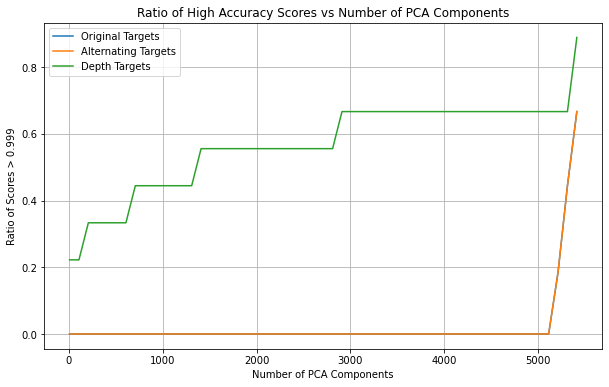

In [29]:
plt.figure(figsize=(10, 6))

def ratio_scores_above_threshold(scores, threshold=0.999):
    return sum(1 for score in scores if score > threshold) / len(scores)

plt.plot(
    list(accuracy_scores.keys()),
    [ratio_scores_above_threshold(scores) for scores in accuracy_scores.values()],
    label="Original Targets",
)
plt.plot(
    list(accuracy_scores_alt.keys()),
    [ratio_scores_above_threshold(scores) for scores in accuracy_scores_alt.values()],
    label="Alternating Targets",
)
plt.plot(
    list(accuracy_scores_depth.keys()),
    [ratio_scores_above_threshold(scores) for scores in accuracy_scores_depth.values()],
    label="Depth Targets",
)

plt.xlabel("Number of PCA Components")
plt.ylabel("Ratio of Scores > 0.999")
plt.title("Ratio of High Accuracy Scores vs Number of PCA Components")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from matplotlib import pyplot as plt

accuracy_scores1 = calculate_accuracy_scores(pca, state_space, targets, start=1000, end=2000, step=5)
accuracy_scores_alt1 = calculate_accuracy_scores(pca, state_space, targets_alt, start=1000, end=2000, step=5)
# accuracy_scores_depth1 = calculate_accuracy_scores(pca1, state_space, targets_depth, start=1000, end=2000, step=5)


100%|██████████| 200/200 [00:12<00:00, 15.43it/s]


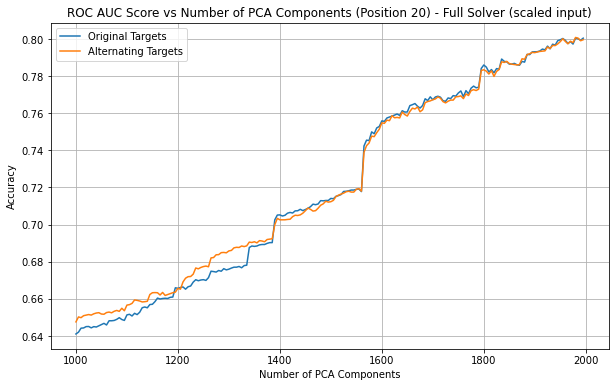

In [42]:
plt.figure(figsize=(10, 6))

# Assuming we want to plot the first position (index 0)
position_to_plot = 20

plt.plot(
    list(accuracy_scores1.keys()),
    [scores[position_to_plot] for scores in accuracy_scores1.values()],
    label="Original Targets",
)
plt.plot(
    list(accuracy_scores_alt1.keys()),
    [scores[position_to_plot] for scores in accuracy_scores_alt1.values()],
    label="Alternating Targets",
)

# plt.plot(
#     list(accuracy_scores_depth1.keys()),
#     [scores[6] for scores in accuracy_scores_depth1.values()],
#     label="Depth Targets",
# )
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.title(f"ROC AUC Score vs Number of PCA Components (Position {position_to_plot}) - Full Solver (scaled input)")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from matplotlib import pyplot as plt

accuracy_scores2 = calculate_accuracy_scores(pca1, state_space, targets, start=1000, end=2000, step=5)
accuracy_scores_alt2 = calculate_accuracy_scores(pca1, state_space, targets_alt, start=1000, end=2000, step=5)
# accuracy_scores_depth1 = calculate_accuracy_scores(pca1, state_space, targets_depth, start=1000, end=2000, step=5)


100%|██████████| 200/200 [00:13<00:00, 15.28it/s]


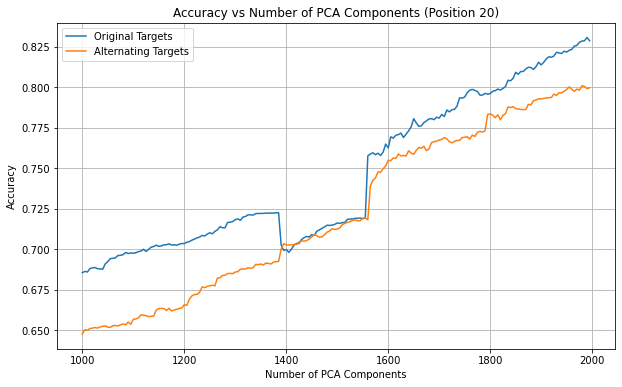

In [41]:


plt.figure(figsize=(10, 6))

# Assuming we want to plot the first position (index 0)
position_to_plot = 20

plt.plot(
    list(accuracy_scores2.keys()),
    [scores[position_to_plot] for scores in accuracy_scores2.values()],
    label="Original Targets",
)
plt.plot(
    list(accuracy_scores_alt2.keys()),
    [scores[position_to_plot] for scores in accuracy_scores_alt1.values()],
    label="Alternating Targets",
)

# plt.plot(
#     list(accuracy_scores_depth1.keys()),
#     [scores[6] for scores in accuracy_scores_depth1.values()],
#     label="Depth Targets",
# )
plt.xlabel("Number of PCA Components")
plt.ylabel("ROC AUC Score")
plt.title(f"ROC AUC Score vs Number of PCA Components (Position {position_to_plot}) - Arpack Solver")
plt.legend()
plt.grid(True)
plt.show()

In [301]:
accuracy_scores2 = calculate_accuracy_scores(pca1, state_space, targets, start=1500, end=1600, step=1)


100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


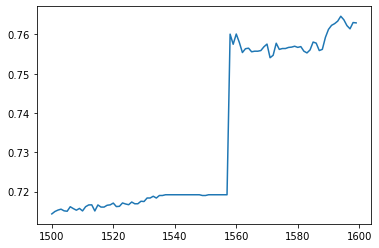

In [304]:
plt.plot(
    list(accuracy_scores2.keys()),
    [scores[position_to_plot] for scores in accuracy_scores2.values()],
    label="Original Targets",
)

In [362]:
i = np.diff(np.array([scores[position_to_plot] for scores in accuracy_scores2.values()])).argmax()
i = list(accuracy_scores2.keys())[i]

In [363]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LinearRegression(fit_intercept=False)
x = state_space_pca[:, :i]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict(x)

roc_auc_score(targets[:, position_to_plot], preds)
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7216456081896696

In [366]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LinearRegression(fit_intercept=False)
x = state_space_pca[:, :i]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict(x)

roc_auc_score(targets[:, position_to_plot], preds)
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7216456081896696

In [390]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LogisticRegression(fit_intercept=False)
x = state_space_pca[:, :i]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict_proba(x)

roc_auc_score(targets[:, position_to_plot], preds[:, 1])
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7221626057520826

In [374]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LogisticRegression(fit_intercept=True)
x = state_space_pca[:, :i]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict_proba(x)

roc_auc_score(targets[:, position_to_plot], preds[:, 1])
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7206286489173634

In [367]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LinearRegression(fit_intercept=False)
x = state_space_pca[:, :i+1]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict(x)

roc_auc_score(targets[:, position_to_plot], preds)
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7612624021006342

In [368]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LinearRegression(fit_intercept=True)
x = state_space_pca[:, :i]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict(x)

roc_auc_score(targets[:, position_to_plot], preds)
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7211388321387686

In [370]:
state_space_pca = pca1.transform(state_space)
lin_probe1 = LinearRegression(fit_intercept=True)
x = state_space_pca[:, :i+1]
lin_probe1.fit(x, targets[:, position_to_plot])
preds = lin_probe1.predict(x)

roc_auc_score(targets[:, position_to_plot], preds)
# accuracy_score(targets[:, position_to_plot], preds > 0.5)

0.7615877057606492

100%|██████████| 55/55 [00:03<00:00, 14.28it/s]


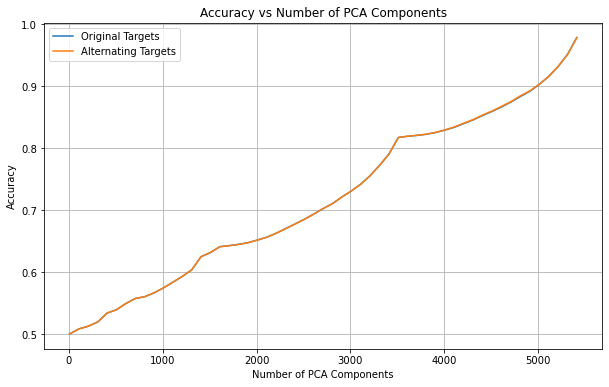

In [116]:
from matplotlib import pyplot as plt

accuracy_scores = calculate_accuracy_scores(pca1, state_space, targets)
accuracy_scores_alt = calculate_accuracy_scores(pca1, state_space, targets_alt)

plt.figure(figsize=(10, 6))
plt.plot(list(accuracy_scores.keys()), list(accuracy_scores.values()), label='Original Targets')
plt.plot(list(accuracy_scores_alt.keys()), list(accuracy_scores_alt.values()), label='Alternating Targets')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
state_space.shape

from torch import nn
class AutoEncoder(nn.Module):
    def __init__(self, d_in, d_hidden, activation='relu'):
        super().__init__()
        self.encoder = nn.Embedding(d_in, d_hidden)
        self.decoder = nn.Linear(d_hidden, d_in)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.activation(x)
        x = self.decoder(x)
        return x

(5478, 5478)

In [281]:
import torch
from torch import nn


class AutoEncoder(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.encoder = nn.Embedding(d_in, d_hidden)
        self.decoder = nn.Linear(d_hidden, d_in)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.activation(x)
        x = self.decoder(x)
        return x


def train_autoencoder(
    model, weights, num_epochs=100, learning_rate=0.001, device="cuda"
):
    if isinstance(weights, np.ndarray):
        weights = torch.tensor(weights, dtype=torch.float32)

    model = model.to(device)
    weights = weights.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(weight=weights)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Create input tensor (indices)
        input_indices = torch.arange(weights.shape[0], device=device)

        # Forward pass
        output = model(input_indices)

        # Compute loss
        loss = criterion(output, input_indices)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}")

    return model


model = AutoEncoder(weight.shape[0], 64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_autoencoder(model, weight, device=device, num_epochs=5000)


Epoch [10/5000], Loss: 8.33911133
Epoch [20/5000], Loss: 7.99675417
Epoch [30/5000], Loss: 7.65780210
Epoch [40/5000], Loss: 7.32029390
Epoch [50/5000], Loss: 6.98230934
Epoch [60/5000], Loss: 6.64223099
Epoch [70/5000], Loss: 6.29880190
Epoch [80/5000], Loss: 5.95112324
Epoch [90/5000], Loss: 5.59864759
Epoch [100/5000], Loss: 5.24126863
Epoch [110/5000], Loss: 4.87941265
Epoch [120/5000], Loss: 4.51416874
Epoch [130/5000], Loss: 4.14745712
Epoch [140/5000], Loss: 3.78204679
Epoch [150/5000], Loss: 3.42136025
Epoch [160/5000], Loss: 3.06926417
Epoch [170/5000], Loss: 2.72989607
Epoch [180/5000], Loss: 2.40754008
Epoch [190/5000], Loss: 2.10626054
Epoch [200/5000], Loss: 1.82931900
Epoch [210/5000], Loss: 1.57865894
Epoch [220/5000], Loss: 1.35487127
Epoch [230/5000], Loss: 1.15751398
Epoch [240/5000], Loss: 0.98547542
Epoch [250/5000], Loss: 0.83721107
Epoch [260/5000], Loss: 0.71083081
Epoch [270/5000], Loss: 0.60417360
Epoch [280/5000], Loss: 0.51493245
Epoch [290/5000], Loss: 0.440

In [238]:
input_indices = torch.arange(weight.shape[0], device=device)
out = model(input_indices)
from torch.nn.functional import softmax
out = softmax(out, dim=1)

out.max(dim=1).values.min(), out.max(dim=1).values.max()

(tensor(0.9993, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>))

torch.return_types.max(
values=tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'))

In [284]:
# encode

encoded = model.encoder(torch.arange(weight.shape[0], device=device))
encoded = model.activation(encoded)
decoded = softmax(model.decoder(encoded), dim=1)


In [222]:
# encoded.shape

data = encoded.cpu().detach().numpy()

lin_reg = LinearRegression()
lin_reg.fit(data, targets[:, 20])
preds = lin_reg.predict(data)


In [279]:
# encoded.shape

data = encoded.cpu().detach().numpy()

lin_reg = LinearRegression()
lin_reg.fit(data, targets[:, 20])
preds = lin_reg.predict(data)
roc_auc_score(targets[:, 20], preds)

0.9971847036864937

In [283]:
# encoded.shape

data = encoded.cpu().detach().numpy()

lin_reg = LinearRegression()
lin_reg.fit(data, targets[:, 20])
preds = lin_reg.predict(data)
roc_auc_score(targets[:, 20], preds)

0.5653879826175896

In [287]:
# encoded.shape

datad = decoded.cpu().detach().numpy()

lin_reg = LinearRegression()
lin_reg.fit(datad, targets[:, 20])
preds = lin_reg.predict(datad)
roc_auc_score(targets[:, 20], preds)

LinAlgError: SVD did not converge in Linear Least Squares

In [240]:
# encoded.shape

data = encoded.cpu().detach().numpy()

lin_reg = LinearRegression()
lin_reg.fit(data, targets[:, 20])
preds = lin_reg.predict(data)
roc_auc_score(targets[:, 20], preds)

0.7672505042612345

In [241]:
# encoded.shape

data = encoded.cpu().detach().numpy()

lin_reg = LogisticRegression(max_iter=10000)
lin_reg.fit(data, targets[:, 20])
preds = lin_reg.predict_proba(data)
roc_auc_score(targets[:, 20], preds[:, 1])

0.7702471918425199

In [ ]:
# encoded.shape

data = encoded.cpu().detach().numpy()

lin_reg = LogisticRegression(max_iter=10000)
lin_reg.fit(data, targets[:, 20])
preds = lin_reg.predict_proba(data)
roc_auc_score(targets[:, 20], preds[:, 1])

0.7702471918425199

In [269]:
# SVC

data = encoded.cpu().detach().numpy()

svm = SVC(random_state=42, probability=True)
svm.fit(data, targets[:, 20])
preds = svm.predict_proba(data)
# roc_auc_score(targets[:, 20], preds)

In [270]:

linear_svc = SVC(random_state=42, probability=True, kernel='linear')
linear_svc.fit(data, targets[:, 20])
preds_linear = linear_svc.predict_proba(data)
roc_auc_score(targets[:, 20], preds_linear[:, 1])

0.2590401968241277

In [271]:

roc_auc_score(targets[:, 20], preds_linear[:, 0])

0.7409598031758724

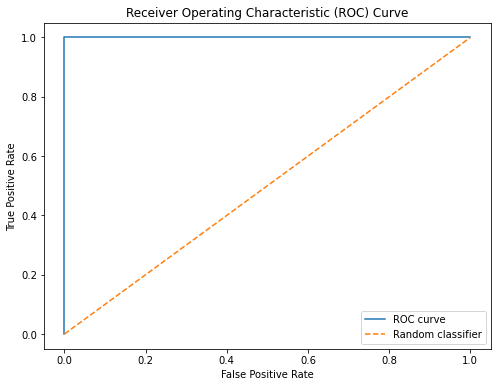

In [252]:
# Create ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(targets[:, 20], preds[:, 0])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [254]:
tpr

array([0.00000000e+00, 6.32111252e-04, 1.00000000e+00, 1.00000000e+00])

In [260]:
targets[:, 20].sum()

1582.0

In [264]:
((preds[:, 0] > thresholds[-2]) == targets[:, 20]).mean()

0.9998174516246805

In [265]:
svm.kernel

'rbf'

In [250]:
roc_auc_score(targets[:, 20], preds[:, 0])

1.0

In [223]:
roc_auc_score(targets[:, 20], preds)

0.7672505042612345

0.7702471918425199

In [220]:
roc_auc_score(targets_alt[:, 20], preds)

0.7743554173736695

In [224]:
state_pca = pca1.transform(state_space)

In [272]:
lr_pca = LogisticRegression()
lr_pca.fit(state_pca[:, :1024], targets[:, 20])
preds_pca = lr_pca.predict_proba(state_pca[:, :1024])[:, 1]
roc_auc_score(targets[:, 20], preds_pca)

0.6852936948525117

In [274]:
lr_pca = LogisticRegression()
lr_pca.fit(state_pca[:, :1024], targets_alt[:, 20])
preds_pca = lr_pca.predict_proba(state_pca[:, :1024])[:, 1]
roc_auc_score(targets_alt[:, 20], preds_pca)

0.6927002584931655

In [293]:
lr_pca = LogisticRegression()
lr_pca.fit(state_pca[:, :64], targets_alt[:, 20])
preds_pca = lr_pca.predict_proba(state_pca[:, :64])[:, 0]
roc_auc_score(targets_alt[:, 20], preds_pca)

0.5265263848614503